## Análisis multivariado

En esta sección se realiza el análisis multivariado del proyecto, la idea detrás de dicho apartado es identificar efectos simultáneos que diferentes variables predictoras podrían tener sobre el target. Por un lado, el estudio multivariante permitiría determinar posibles efectos indirectos que una predictora puede tener sobre el target, a partir de un tercer *feature*. Por otro lado, ayudaría a encontrar posibles correlaciones no despreciables entre variables independientes que sugerirían la eliminación de alguna de ellas en pos de reducir la complejidad del modelo. 

La sección se estructura de la siguiente manera. En primer lugar, realizamos la carga de las librerías que vamos a utilizar como el dataset objetivo. Como explicamos antes en el apartado de [**análisis bivariado**](https://colab.research.google.com/drive/1yY5Z5Sr65W-V0U5Xm_v1Iri0S9_E08_s#scrollTo=xUxe8UqFzGEG), el dataset es reducido al período de tiempo que corresponde al grupo de entrenamiento. En segundo lugar, se crean tres variables categóricas que interesan incorporara al análisis multivariado. Los mismos son los siguientes: 

1. Variable binaria que indique si la variación interdiaria del precio del bitcoin es positiva o no
2. Shock Covid-19
3. Ingreso de ethereum al *exchange* Binance

La primera hace mención a la variación entre dos días del precio de bitcoin. Como vimos en análisis anteriores, el precio del bitcoin está altamente asociado de forma positiva con el precio de ethereum y puede ser un importante predictor directo de la cotización futura de la variable a predecir. La pregunta ahora radica en si hay un efecto indirecto entre el precio actual de ambas criptomonedas que puede correlacionar con la cotización futura de ethereum, es decir, interesa analizar si la cotización de bitcoin tiene un efecto en el precio actual de ethereum que podría relacionarse con los movimientos futuros de esta criptomoneda. 

En el segundo caso, el shock exógeno del covid-19 generó una disrupción importante tanto en el ámbito cotidiano de las personas como en los mercados financieros. Siguiendo a [**El País**](https://elpais.com/economia/2020-03-12/las-bolsas-sufren-en-la-apertura-y-el-ibex-cae-mas-de-un-5.html), el 12 de marzo del 2020 se recuerda como un "terremoto económico global de una magnitud impredecible", con el desplome global de las bolsas a partir de los pronósticos poco alentadores acerca de la trayectoria de las economías post-covid. Debido a esto, en esta sección queremos ver qué rasgos podríamos encontrar al separar la base en dos momentos diferentes, un período pre-covid y uno post-covid. Eligiendo al 12 de marzo del 2020 como momento bisagra. 

Por último, un segundo quiebre que queremos analizar se encuentra en el posicionamiento de ethereum como una inversión globalmente reconocida dentro del mercado de criptomonedas y su relación con otras variables correlacionadas entre sí. Para ello, utilizamos como *proxy* la fecha en donde se funda [**Binance**](https://www.binance.com/en/support/announcement/115000599831), una de las plataformas más grandes e importantes de *trading* de criptomonedas que incluye a ethereum como uno de sus activos digitales a ofertar. 

Para simplificar el análisis, solamente utilizamos el primer rezago del precio de ethereum como target, debido a que entendemos que los patrones encontrados en esta sección se replicarían en los demás rezagos.

In [1]:
# cargamos las librerías
import pandas as pd 
import numpy as np  
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import seaborn as sns
from seaborn import distplot
import scipy as scp
# muteamos algunos warnings esperables que no afectan los outputs de los códigos
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# importamos dataset
aux = 'https://drive.google.com/file/d/1GWaKdMRk4Fx9qGgBMioNeO3E7_I3bA8k/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
df = pd.read_csv(link)
df = df.set_index('Date')

# subconjunto a utilizar: dataset de entrenamiento
start = df.index[0]
# Enfoque de validación
train = df[start:'2020-12-31']
train.head()

,Volume USDT_btc,cryptocurrency_adjusted,crypto_adjusted,bitcoin_adjusted,bitcoin price_adjusted,ethereum_adjusted,ethereum price_adjusted,stock market_adjusted,wall street_adjusted,interest rate_adjusted,...,y_lag4,y_lag5,y_lag6,y_lag7,unix_btc,open_btc,high_btc,low_btc,close_btc,Volume BTC_btc
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-08,3.8010,0.0,0.48,1.74,0.27,0.0,0.0,1.45,8.32,16.38,...,2.150,1.825,1.310,1.645,1438992000,275.92,282.24,262.65,263.00,1032.69
2015-08-11,0.9435,0.0,0.88,1.89,0.49,0.0,0.0,2.61,9.92,19.74,...,1.825,1.310,1.645,1.520,1439251200,266.22,269.26,261.61,269.26,247.49
2015-08-12,2.5580,0.0,0.87,1.83,0.47,0.0,0.0,3.48,10.40,20.58,...,1.310,1.645,1.520,1.410,1439337600,269.26,275.63,263.33,265.41,682.19
2015-08-13,3.1890,0.0,0.87,1.95,0.35,0.0,0.0,2.61,10.40,18.48,...,1.645,1.520,1.410,1.515,1439424000,265.41,269.88,260.00,263.00,838.99
2015-08-14,2.1290,0.0,0.83,1.68,0.32,0.0,0.0,2.32,10.88,16.80,...,1.520,1.410,1.515,1.615,1439510400,263.00,265.00,255.00,265.00,556.23


### Variación interdiaria del bitcoin

La variable *var_price_btc* representa una binaria que indica si la variación interdiaria de bitcoin subió o no. Para crearla primero calculamos la variación interdiaria de la cotización del precio de apertura de bitcoin bajo la siguiente fórmula: 
$$ 
Pvarid_{btc} = (Pbtc_{t}/Pbtc_{t-1})-1
$$

Donde $Pvarid_{btc}$ es la variación interdiaria del precio de apertura de bitcoin y $Pbtc_{t}$ y $Pbtc_{t-1}$ son los precios de apertura del día actual y del día anterior, respectivamente. Cabe aclarar que elegir el precio de cierre en vez del de apertura no cambiaría los resultados del análisis. 

Una vez calculado la variación interdiaria simplemente le asignamos el valor string 'No subió' si la variación es negativa o cero, y 'Subió' si es positiva. 

In [3]:
# creación de dummy de si la variación entre días subió o no
train['var_price_btc'] = train['open_btc'].div(train['open_btc'].shift(1))-1
train.loc[train['var_price_btc'] <= 0,'var_price'] = 'No subió'
train.loc[train['var_price_btc'] > 0,'var_price'] = 'Subió'

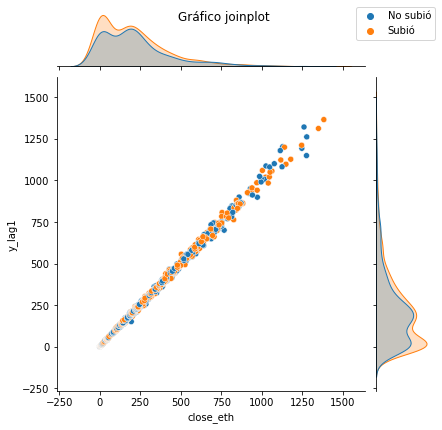

In [4]:
# gráfico multivariado var id precio bitcoin versus target
p = sns.jointplot(data=train, x="close_eth", y="y_lag1", hue='var_price')
p.fig.suptitle("Gráfico joinplot")

# omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

Como se puede ver en el gráfico anterior, los resultados no sugieren un efecto indirecto de la variación interdiaria del bitcoin en la cotización futura de ethereum, a través del precio actual de ethereum. De hecho, las distribuciones son bastantes similares aún diferenciando por la categórica de si el precio entre días de bitcoin subió o no. El gráfico podría indicar que incluir la variación interdiaria del precio de bitcoin no agregaría información adicional indirecta en la cotización de ethereum. 

### Período pre pandemia y post pandemia

Siguiendo la fecha bisagra denominada "terremoto económico global de una magnitud impredecible", se crea la *dummy* *shock-COVID* que indica la etapa 'Pre-COVID', esto es, anterior al 12 de marzo de 2020, y 'Post-COVID' como el período de pandemia.   

In [5]:
# creación de dummy pre y post pandemia
train.loc[train.index < '2020-03-12', 'Shock-COVID'] = 'Pre-COVID'
train.loc[train.index >= '2020-03-12', 'Shock-COVID'] = 'Post-COVID'

Una vez creada la variable binaria pasamos a analizar su efecto indirecto en la relación entre el precio de cierre de ethereum y el target. Esto lo podemos ver en el siguiente gráfico: 

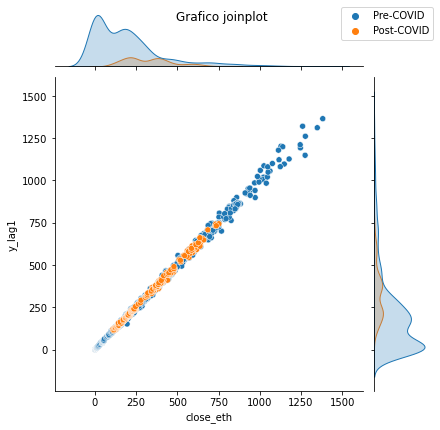

In [6]:
# Comparación precio ethereum real contra precio ethereum 
# para el día siguiente según el shock de COVID 

p = sns.jointplot(data=train, x="close_eth", y="y_lag1", hue='Shock-COVID')
p.fig.suptitle("Grafico joinplot")

# omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

En contraste con el análisis de la variación interdiaria del precio de bitcoin, la separación de períodos pre y post pandemia no resulta indiferente al evaluar la correlación entre el precio presente de ethereum y su cotización futura. Claramente, la correlación entre variables se da en los tramos de menores precios en contexto de pandemia, lo que indica no sólo que dicho acontecimiento global contrajo los precios de la criptomoneda, sino que la pandemia podría influenciar negativamente el precio corriente de ethereum y afectar así la cotización futura de la misma. Debido a esto, resulta imporante agregar dicha variable binaria al análisis. 

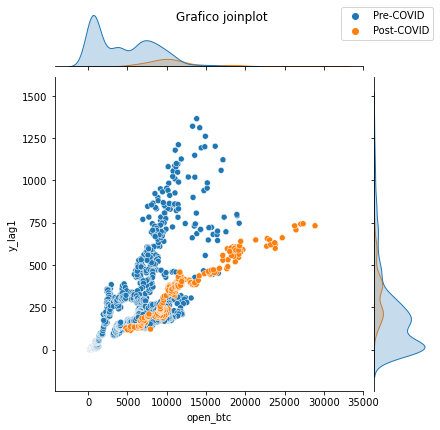

In [8]:
# Comparación precio bitcoin contra precio ethereum 
# para el día siguiente según el shock de COVID 

p = sns.jointplot(data=train, x="open_btc", y="y_lag1", hue='Shock-COVID')
p.fig.suptitle("Grafico joinplot")

#omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

Como vimos en el análisis bivariado, el precio de apertura de bitcoin presenta una relación no lineal con el precio futuro de ethereum. La relación podría ser representada por dos funciones lineales que se ajusten sobre los dos segmentos que se muestran en la nube de puntos. Lo interesante al ver el gráfico anterior es que a este hallazgo se agrega que, de los valores dentro de uno de los segmentos (el de menor pendiente) la mayoría se producen en el período posterior al shock de la pandemia. 

### Período pre y post Binance

Por último, contemplamos el período previo y posterior a la inclusión de binance como plataforma de *trading* y la inclusión de la criptomoneda ethereum como listado de activos digitales en la plataforma. Para ello, utilizamos como fecha bisagra el 17 de agosto de 2017, fecha en que se funda la plataforma. Con esta variable binaria realizamos el mismo ejercicio de las subsecciones anteriores. 

In [10]:
train.loc[train.index < '2017-08-17', 'Binance-Listing'] = 'No-Listado'
train.loc[train.index >= '2017-08-17', 'Binance-Listing'] = 'Listado'

El hecho de que ethereum pase a estar listado en una de las plataformas más importantes de *trading* digital repercute en la popularidad de la misma. Dicha popularidad implica un aumento en los precios de negociación, tanto impulsado por el mayor interés por parte de la demanda como por los requerimientos de la oferta de la criptomonedas. Por lo que deberíamos esperar una segmentación marcada en la relación entre el precio de ethereum con su rezago. Esta hipótesis se puede observar en el siguiente gráfico:

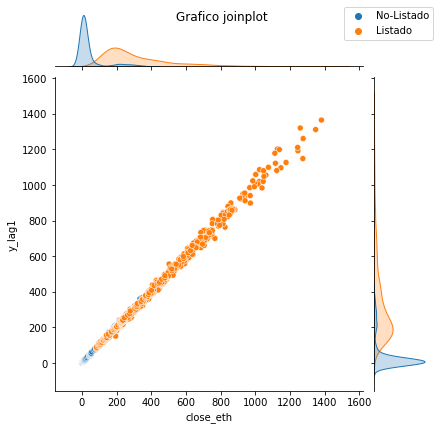

In [11]:
# Utilización de la binaria Binance-listing con el precio de cierre de ethereum
p = sns.jointplot(data=train, x="close_eth", y="y_lag1", hue='Binance-Listing')
p.fig.suptitle("Grafico joinplot")

# omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

La distribución del precio de ethereum depende claramente de qué período estamos hablando. Al no listarse su cotización en grandes plataformas de *exchange* los precios son considerablemente menores y más concentrados en intervalos cortos de valores. Mientras que al pasar a listarse la criptomoneda incrementa sus precios y su dispersión es considerablemente mayor. 

Por último, realizamos el mismo análisis pero con el precio de apertura de bitcoin. El gráfico se ve a continuación:

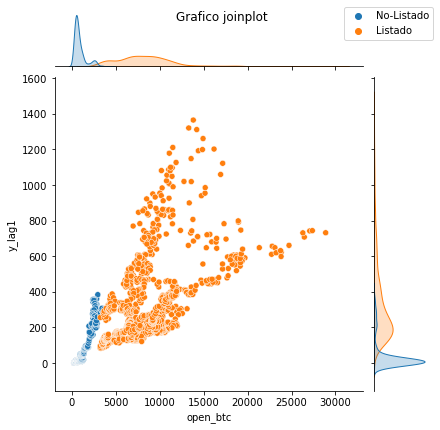

In [13]:
# Utilización de la binaria Binance-listing con el precio de apertura de bitcoin
p = sns.jointplot(data=train, x="open_btc", y="y_lag1", hue='Binance-Listing')
p.fig.suptitle("Grafico joinplot")

#omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

Claramente, los resultados sugieren que las distribuciones son diferentes según si hablamos del período listado o no. La relación entre el precio actual de bictoin se relaciona lineal y positivamente con el precio futuro de ethereum si solamente consideramos el período donde esta última no se encontraba listada en Binance. Mientras que la forma no lineal de la relación se da completamente en el período posterior.  